In [1]:
# Define the time step.
TIME_STEPS = 1

### Load & setup train-test data

In [2]:
import pandas as pd
data = pd.read_csv('/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')
data['Date'] = pd.to_datetime(data['Date'])
print(f"data.shape: {data.shape}")
data.head()
data = data[['Date', 'BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Close']]

data.shape: (2430, 48)


In [3]:
import numpy as np

start_day_p2 = pd.Timestamp(2015, 8, 7)
test_day_p2 = pd.Timestamp(2018, 4, 1)
end_day_p2 = pd.Timestamp(2018, 9, 30)

period2 = data[(data["Date"] >= start_day_p2) & (data["Date"] <= end_day_p2)].reset_index(drop = True)
# period2 = data[(data["Date"] <= end_day_p2)].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)
train_dataset_p2 = train_dataset_p2.drop(columns = ["Date"])
test_dataset_p2 = test_dataset_p2.drop(columns = ["Date"])

In [4]:
from DataProcessor import DataProcessor
data_processor = DataProcessor(train_dataset=train_dataset_p2, test_dataset=test_dataset_p2, target_column="BTC_Close", time_steps=TIME_STEPS)
X_train, y_train, X_test, y_test = data_processor.prepare_data()
X_scaler = data_processor.X_scaler

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (967, 1, 4)
y_train.shape: (967,)
X_test.shape: (182, 1, 4)
y_test.shape: (182,)


### Model stacking

In [5]:
# 5 models each with different number of layers and units
UNITS1 = [64, 64]
UNITS2 = [32, 32]
UNITS3 = [64, 128, 64]
UNITS4 = [32, 64, 32]
UNITS5 = [128, 128, 256, 256]

DROPOUT1 = [0.2, 0.2]
DROPOUT2 = [0.1, 0.1]
DROPOUT3 = [0.2, 0.3, 0.2]
DROPOUT4 = [0.1, 0.2, 0.1]
DROPOUT5 = [0.2, 0.3, 0.4, 0.5]

EPOCHS = 250
KERNEL_REGULARIZER = None
PATIENCE = 15

UNITS = [UNITS1, UNITS2, UNITS3, UNITS4, UNITS5]
DROPOUTS = [DROPOUT1, DROPOUT2, DROPOUT3, DROPOUT4, DROPOUT5]
VALIDATION_SPLIT = 0.1

In [6]:
from RecurrentRegressor import LSTMRegressor, GRURegressor

lstm_regressors = []
gru_regressors = []

for i in range(5):
    lstm_regressors.append(LSTMRegressor(units=UNITS[i], dropouts=DROPOUTS[i], kernel_regularizer=KERNEL_REGULARIZER, patience=PATIENCE, validation_split=VALIDATION_SPLIT, epochs=EPOCHS))
    gru_regressors.append(GRURegressor(units=UNITS[i], dropouts=DROPOUTS[i], kernel_regularizer=KERNEL_REGULARIZER, patience=PATIENCE, validation_split=VALIDATION_SPLIT, epochs=EPOCHS))

2024-11-28 21:17:45.755979: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 21:17:45.817382: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 21:17:45.904145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 21:17:45.976975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 21:17:45.996912: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 21:17:46.136190: I tensorflow/core/platform/cpu_feature_gu

In [7]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Init base estimators
base_estimators = []

for i in range(len(lstm_regressors)):
    base_estimators.append((f"LSTM_{i+1}", lstm_regressors[i]))
    base_estimators.append((f"GRU_{i+1}", gru_regressors[i]))
    
# Init final estimator
final_estimator = LinearRegression(n_jobs=-1)

for name, estimator in base_estimators:
	estimator.fit(X_train, y_train)

# Init stacking regressor
stacking_regressor = StackingRegressor(estimators=base_estimators, final_estimator=final_estimator, cv="prefit", n_jobs=-1)

In [8]:
# Fit stacking regressor
stacking_regressor.fit(X_train, y_train)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


StackingRegressor(cv='prefit',
                  estimators=[('LSTM_1',
                               LSTMRegressor(dropouts=[0.2, 0.2], epochs=250,
                                             patience=15, units=[64, 64])),
                              ('GRU_1',
                               GRURegressor(dropouts=[0.2, 0.2], epochs=250,
                                            patience=15, units=[64, 64])),
                              ('LSTM_2',
                               LSTMRegressor(dropouts=[0.1, 0.1], epochs=250,
                                             patience=15, units=[32, 32])),
                              ('GRU_2',
                               GRURegressor(dropouts=[0.1, 0.1], epochs=250,
                                            patience=15,...
                                             units=[32, 64, 32])),
                              ('GRU_4',
                               GRURegressor(dropouts=[0.1, 0.2, 0.1],
                                            epochs=250, patience=15,
                                            units=[32, 64, 32])),
                              ('LSTM_5',
                               LSTMRegressor(dropouts=[0.2, 0.3, 0.4, 0.5],
                                             epochs=250, patience=15,
                                             units=[128, 128, 256, 256])),
                              ('GRU_5',
                               GRURegressor(dropouts=[0.2, 0.3, 0.4, 0.5],
                                            epochs=250, patience=15,
                                            units=[128, 128, 256, 256]))],
                  final_estimator=LinearRegression(n_jobs=-1), n_jobs=-1)

In [9]:
y_pred = stacking_regressor.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [10]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100

da = directional_accuracy(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

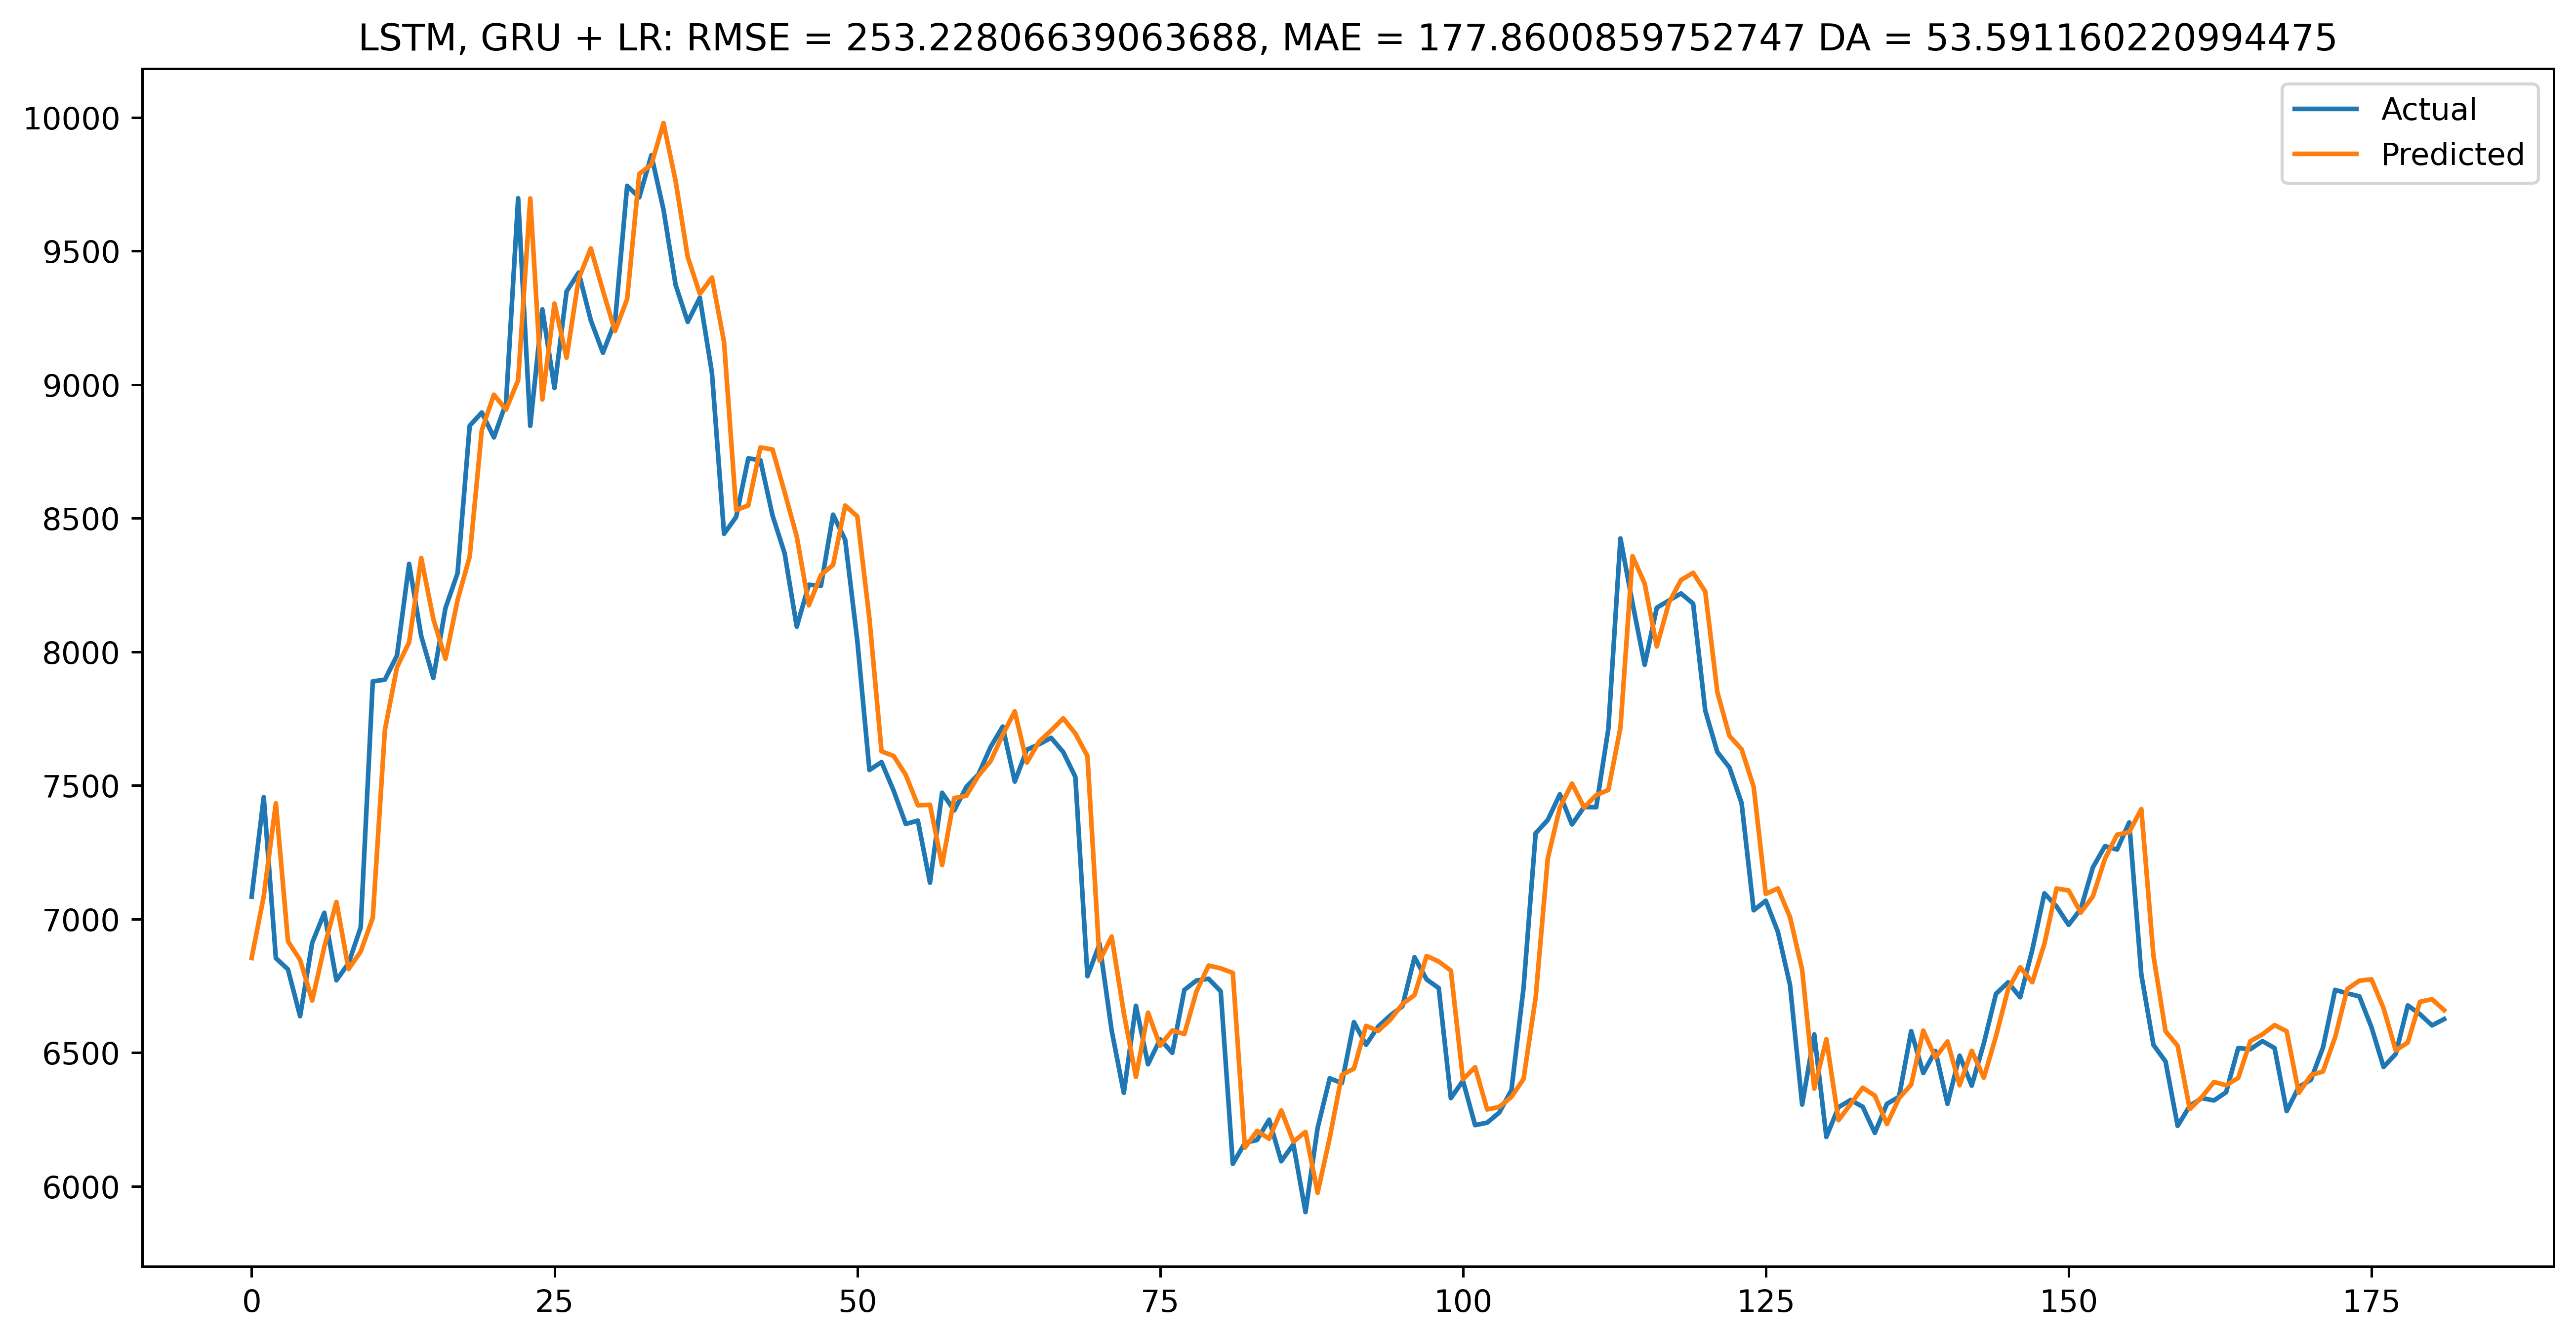

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7), dpi=450)
plt.title(f"LSTM, GRU + LR: RMSE = {rmse}, MAE = {mae} DA = {da}")
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")

plt.legend()
plt.show()

In [12]:
import pickle
name = 'period1'
model = 'stacking'
file = open(f"/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/tianen101/implementations/results/{name}/{model}.pkl", "wb")
pickle.dump(obj=y_pred, file=file)
file.close()

In [13]:
import pickle as pkl

pkl.dump(stacking_regressor, open("/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/tianen101/implementations/models/lstm_gru_lr_ts1_p2.pkl", "wb"))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


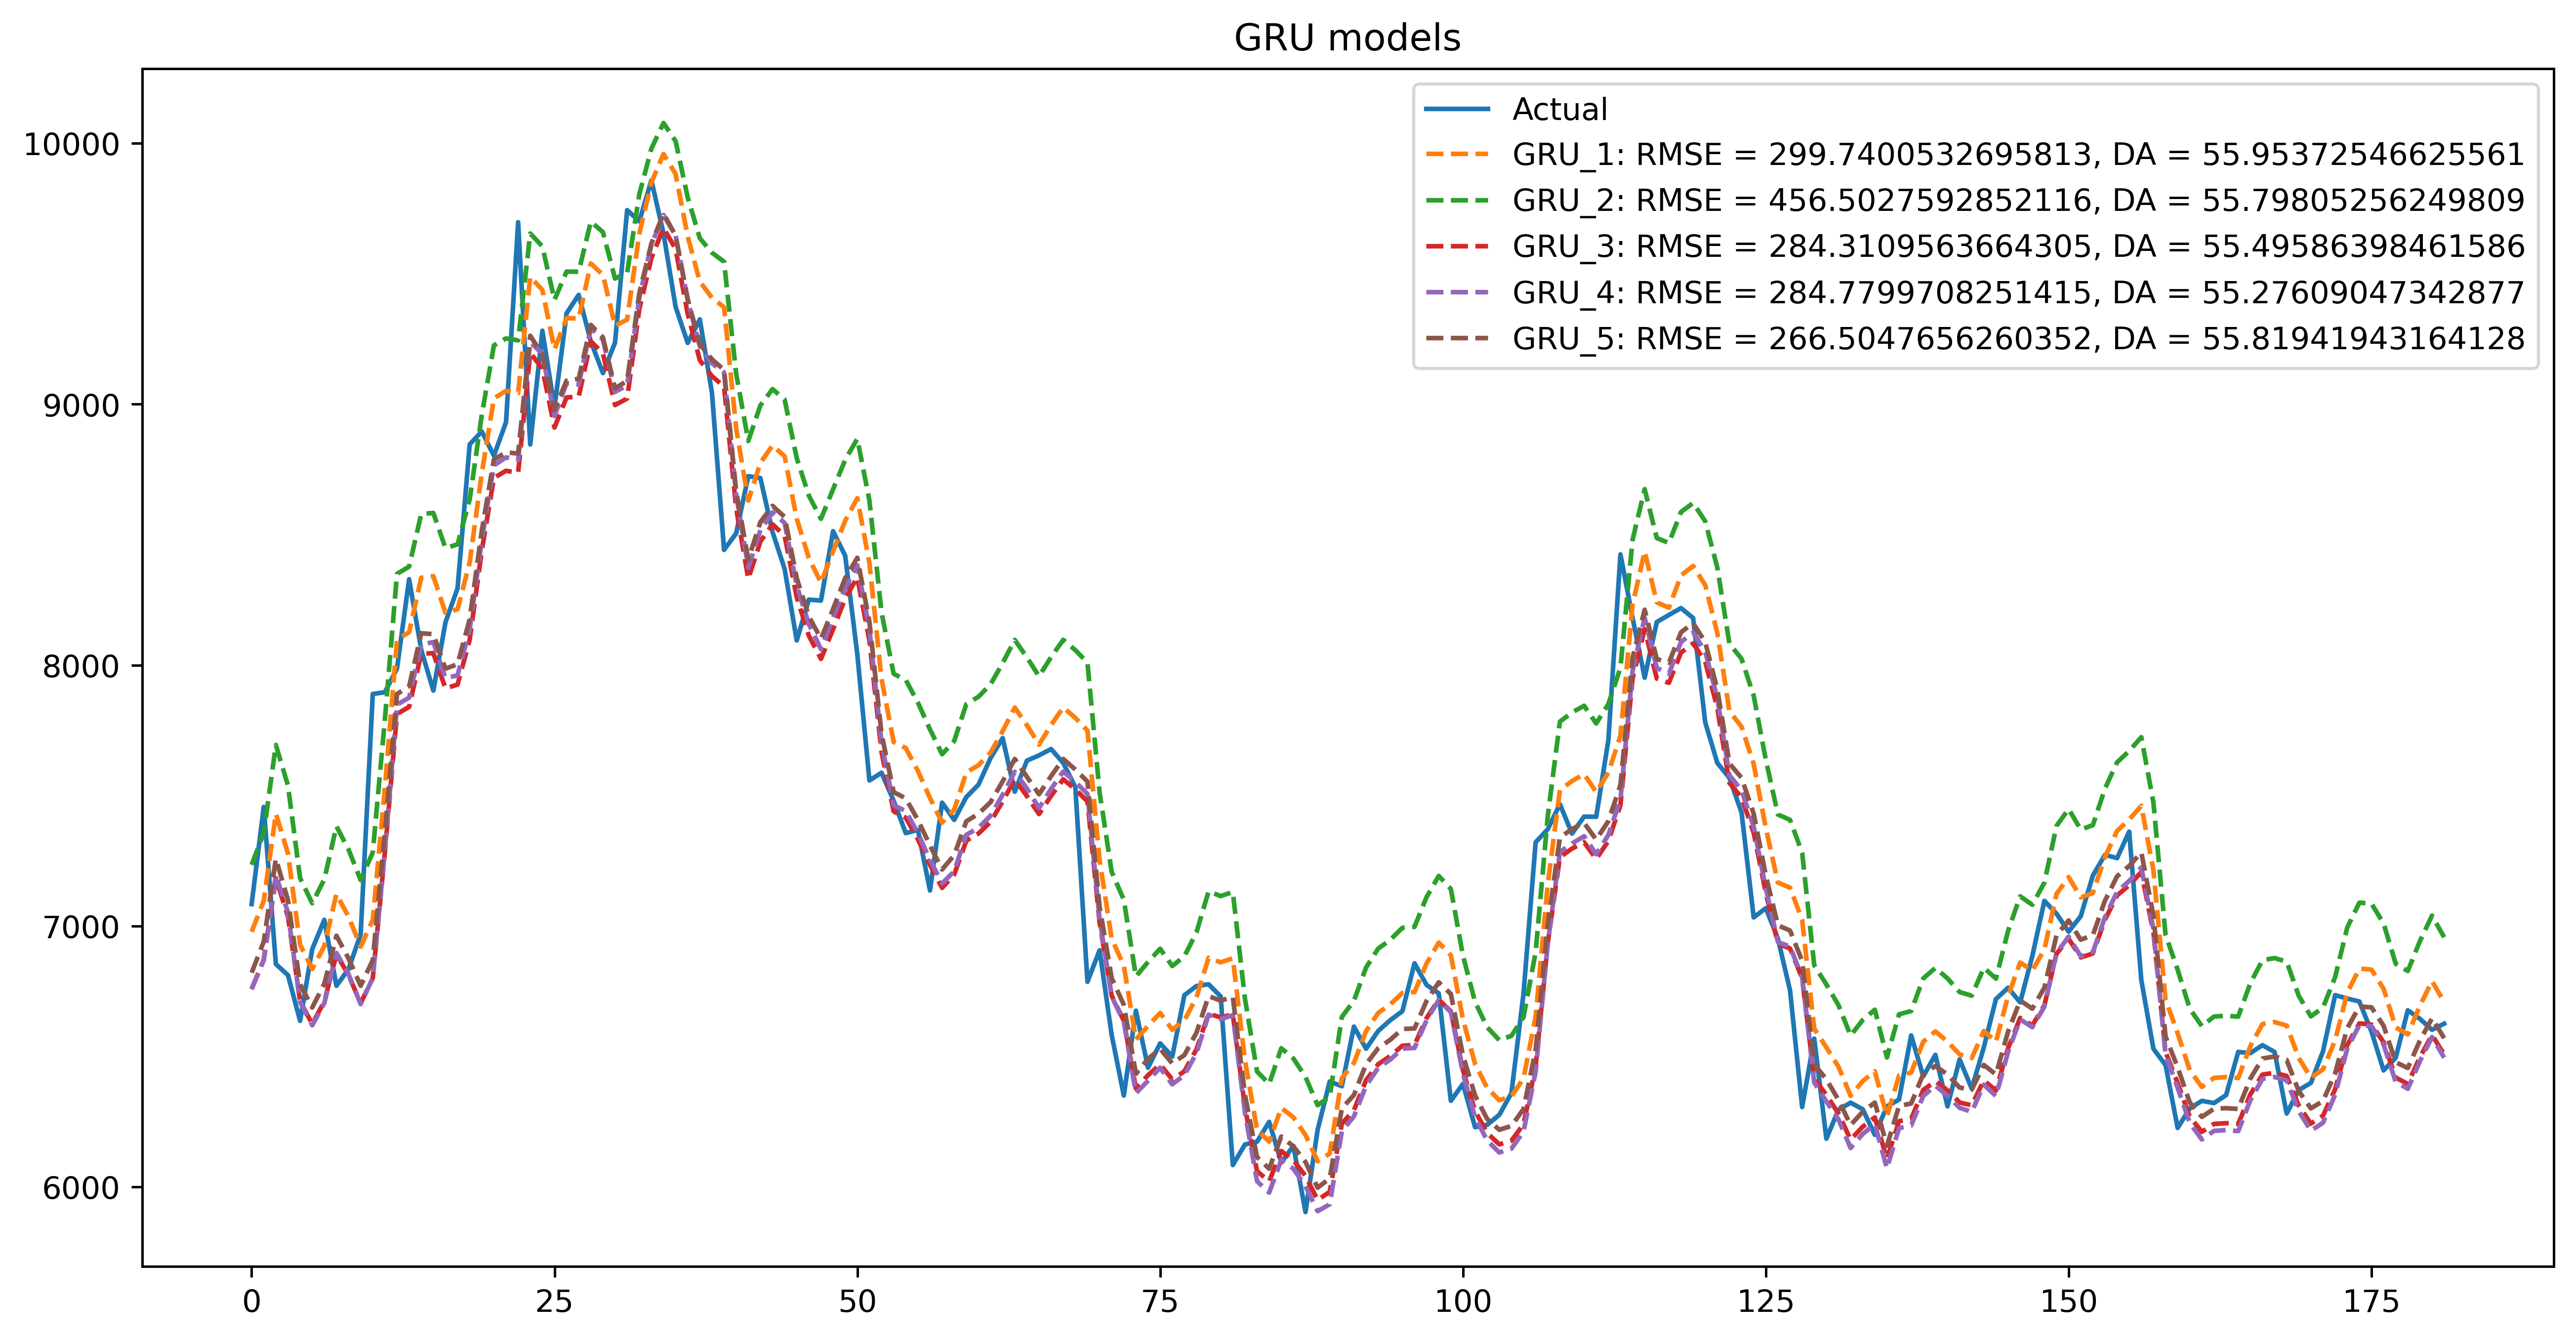

In [14]:
# GRU models
plt.figure(figsize=(14, 7), dpi=450)
plt.title("GRU models")
plt.plot(y_test, label="Actual")
for name, estimator in base_estimators:
	if "GRU" in name:
		y_pred = estimator.predict(X_test)
		rmse = root_mean_squared_error(y_test, y_pred)
		da = directional_accuracy(y_test, y_pred)

		plt.plot(y_pred, label=f"{name}: RMSE = {rmse}, DA = {da}", linestyle="--")
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


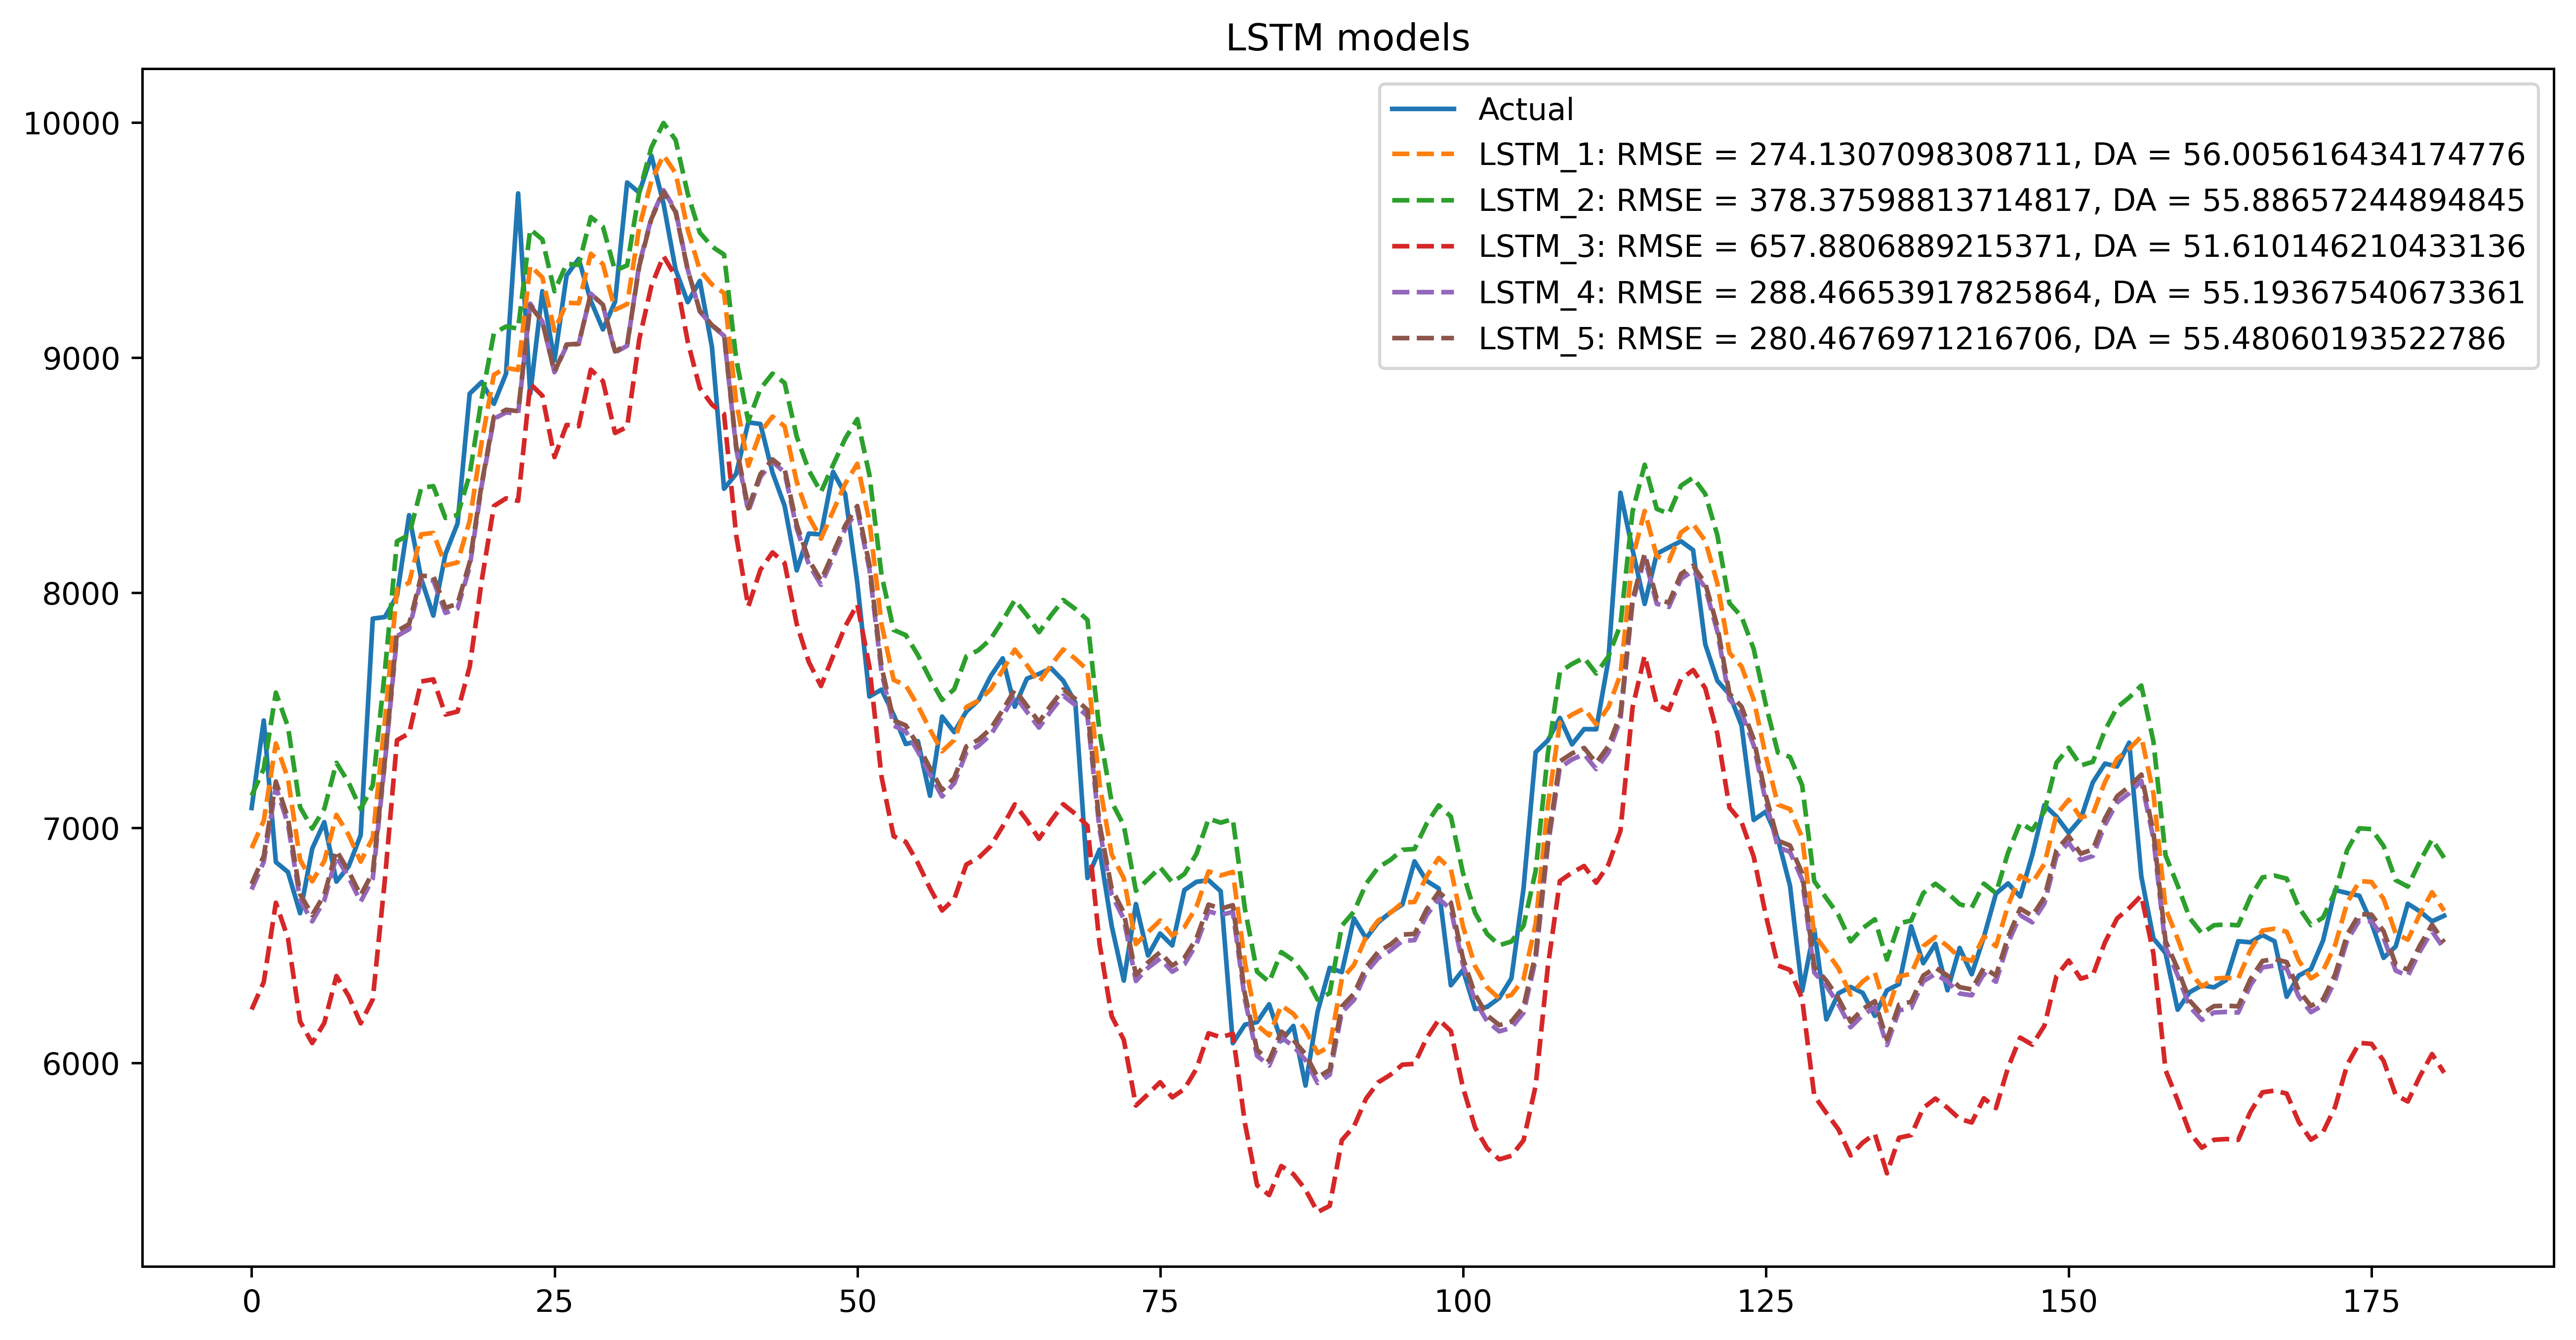

In [15]:
# LSTM models
plt.figure(figsize=(14, 7), dpi=450)
plt.title("LSTM models")
plt.plot(y_test, label="Actual")
for name, estimator in base_estimators:
	if "LSTM" in name:
		y_pred = estimator.predict(X_test)
		rmse = root_mean_squared_error(y_test, y_pred)
		da = directional_accuracy(y_test, y_pred)
		plt.plot(y_pred, label=f"{name}: RMSE = {rmse}, DA = {da}", linestyle="--")
plt.legend()
plt.show()